识别到的位点:
top: Atoms (316,), Position [-1.35       -2.33826859 16.4152    ], vector None
bridge: Atoms (316, 317), Position [ 4.44089210e-16 -2.33826859e+00  1.64152000e+01], vector [1. 0. 0.]
top: Atoms (317,), Position [ 1.35       -2.33826859 16.4152    ], vector None
bridge: Atoms (317, 318), Position [ 2.7        -2.33826859 16.4152    ], vector [1. 0. 0.]
top: Atoms (318,), Position [ 4.05       -2.33826859 16.4152    ], vector None
bridge: Atoms (318, 319), Position [ 5.4        -2.33826859 16.4152    ], vector [1. 0. 0.]
top: Atoms (319,), Position [ 6.75       -2.33826859 16.4152    ], vector None
bridge: Atoms (319, 444), Position [ 8.1        -2.33826859 16.4152    ], vector [1. 0. 0.]
top: Atoms (444,), Position [ 9.45       -2.33826859 16.4152    ], vector None
bridge: Atoms (444, 445), Position [10.8        -2.33826859 16.4152    ], vector [1. 0. 0.]
top: Atoms (445,), Position [12.15       -2.33826859 16.4152    ], vector None
bridge: Atoms (445, 446), Position [13.5      

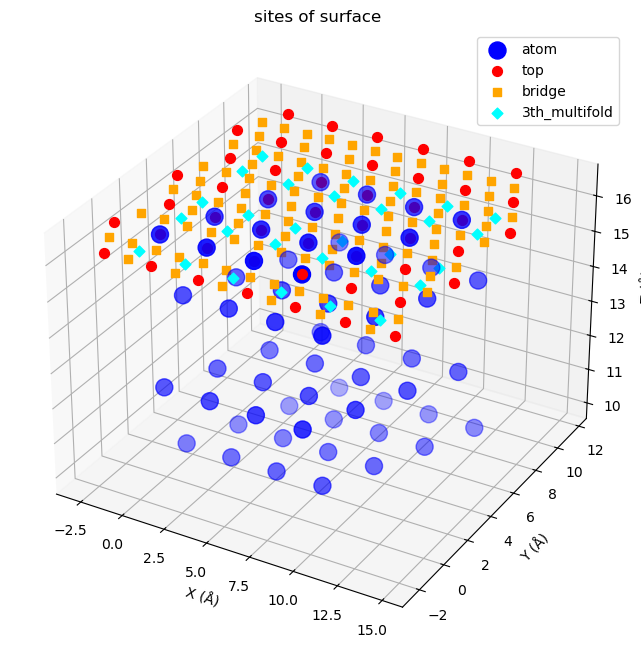

In [ ]:
import numpy as np
from ase import Atoms
from ase.io import read
from scipy.spatial import KDTree, cKDTree
import matplotlib.pyplot as plt
from collections import defaultdict

class SurfaceSiteFinder:
    def __init__(self, atoms: Atoms, surface_direction: int = 2):
        """
        初始化表面位点查找器
        
        参数:
        atoms: ASE Atoms 对象，表示平板结构
        surface_direction: 表面法线方向 (0=x, 1=y, 2=z)
        """
        self.atoms = atoms
        self.surface_direction = surface_direction
        self.grid_points = None
        self.wrapped_points = None
        self.site_atoms = defaultdict(list)
        self.site_positions = {}
        self.site_special_vectors = {}
        self.site_vectors = {}
        self.cell = self.atoms.get_cell()
        self.pbc = self.atoms.get_pbc()
        self._generate_replicas()
    def _generate_replicas(self):
        """生成必要的镜像原子以处理周期性边界条件"""
        # 确定每个方向需要复制的数量
        # 对于最近邻搜索，通常只需要相邻的镜像
        replicas = []
        for i, pbc in enumerate(self.pbc):
            if pbc:
                replicas.append([-1, 0, 1])
            else:
                replicas.append([0])
        
        # 生成所有可能的复制组合
        replica_offsets = np.array(np.meshgrid(*replicas)).T.reshape(-1, 3)
        
        # 存储所有位置（原始+镜像）
        self.all_positions = []
        self.original_indices = []  # 记录每个位置对应的原始原子索引
        
        # 原始原子位置
        original_positions = self.atoms.get_positions()
        for i, pos in enumerate(original_positions):
            self.all_positions.append(pos)
            self.original_indices.append(i)
        # 镜像原子位置
        for offset in replica_offsets:
            # 跳过零偏移（原始位置）
            if np.all(offset == 0):
                continue
            # 应用周期性偏移
            offset_positions = original_positions + offset @ self.cell
            
            for i, pos in enumerate(offset_positions):
                self.all_positions.append(pos)
                self.original_indices.append(i)
        
        self.all_positions = np.array(self.all_positions)
        self.original_indices = np.array(self.original_indices)
    def create_grid(self, grid_spacing: float = 0.1, height_above_surface: float = 5.0):
        """
        在表面上创建密集网格
        
        参数:
        grid_spacing: 网格点间距 (Å)
        height_above_surface: 网格在表面上方的初始高度 (Å)
        """
        # 获取表面原子的坐标
        positions = self.atoms.get_positions()
        
        # 确定表面方向
        if self.surface_direction == 0:  # x方向为表面法线
            surface_coords = positions[:, 1:]
            max_height = np.max(positions[:, 0])
        elif self.surface_direction == 1:  # y方向为表面法线
            surface_coords = positions[:, [0, 2]]
            max_height = np.max(positions[:, 1])
        else:  # z方向为表面法线 (默认)
            surface_coords = positions[:, :2]
            max_height = np.max(positions[:, 2])
        
        # 确定网格的边界
        x_min, y_min = np.min(surface_coords, axis=0)
        x_max, y_max = np.max(surface_coords, axis=0)
        
        # 扩展边界以确保覆盖整个表面
        x_min, x_max = x_min - 2.0, x_max + 2.0
        y_min, y_max = y_min - 2.0, y_max + 2.0
        
        # 创建网格点
        x_grid = np.arange(x_min, x_max, grid_spacing)
        y_grid = np.arange(y_min, y_max, grid_spacing)
        xx, yy = np.meshgrid(x_grid, y_grid)
        
        # 设置网格高度
        if self.surface_direction == 0:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([zz.ravel(), xx.ravel(), yy.ravel()]).T
        elif self.surface_direction == 1:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([xx.ravel(), zz.ravel(), yy.ravel()]).T
        else:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
            
        return self.grid_points
    
    def wrap_grid_to_surface(self, contact_distance: float = 2.0, step_size: float = 0.1,height_above_surface=3.0):
        """
        将网格点向表面平移，直到接近原子
        
        参数:
        contact_distance: 接触距离阈值 (Å)
        step_size: 平移步长 (Å)
        """
        if self.grid_points is None:
            raise ValueError("请先创建网格点")
            
        # 创建原子位置的KD树用于快速最近邻搜索
        atom_positions = self.all_positions
        tree = cKDTree(atom_positions)
        
        # 初始化包裹后的点
        wrapped_points = self.grid_points.copy()
        
        # 确定平移方向
        if self.surface_direction == 0:
            direction = np.array([-1, 0, 0])
        elif self.surface_direction == 1:
            direction = np.array([0, -1, 0])
        else:
            direction = np.array([0, 0, -1])
            
        # 逐步平移网格点
        max_steps = int(height_above_surface / step_size) + 10
        for step in range(max_steps):
            # 计算每个点到最近原子的距离
            distances, indices = tree.query(wrapped_points)
            
            # 找到尚未接触原子的点
            not_contacted = distances > contact_distance
            
            if not np.any(not_contacted):
                break
                
            # 将这些点向表面方向移动
            wrapped_points[not_contacted] += direction * step_size
        
        self.wrapped_points = wrapped_points
        return wrapped_points
    
    def find_sites(self, contact_distance: float = 2.0, multi_site_threshold: float = 2):
        """
        识别表面位点
        
        参数:
        contact_distance: 接触距离阈值 (Å)
        multi_site_threshold: 多重位点识别阈值 (Å)
        """
        if self.wrapped_points is None:
            raise ValueError("请先执行网格包裹")
            
        # 创建原子位置的KD树
        atom_positions = self.all_positions
        tree = cKDTree(atom_positions)
        
        # 对于每个包裹后的网格点，找到接触的原子
        for i, point in enumerate(self.wrapped_points):
            # 找到距离此点在一定范围内的所有原子
            indices = tree.query_ball_point(point, contact_distance)
            
            if indices:
                # 将原子索引转换为可哈希的元组
                atom_tuple = tuple(sorted(indices))
                self.site_atoms[atom_tuple].append(point)
        
        # 识别位点类型并计算位点位置
        for atom_indices, points in self.site_atoms.items():
            if len(atom_indices) == 1:
                # 顶位 - 使用原子位置
                atom_idx = atom_indices[0]
                self.site_positions[atom_indices] = atom_positions[atom_idx]
                self.site_special_vectors[atom_indices]=None
            elif len(atom_indices) == 2:
                #桥位
                site_atoms = atom_positions[list(atom_indices)]
                self.site_positions[atom_indices] = np.mean(site_atoms, axis=0)
                self.site_special_vectors[atom_indices]=(site_atoms[-1]-site_atoms[0])/np.linalg.norm(site_atoms[-1]-site_atoms[0])
            else:
                # 桥位或多重位点 - 使用原子位置的平均值
                site_atoms = atom_positions[list(atom_indices)]
                self.site_positions[atom_indices] = np.mean(site_atoms, axis=0)
                self.site_special_vectors[atom_indices]=None
        
        return self.site_atoms, self.site_positions,self.site_special_vectors
    
    def classify_sites(self, multi_site_threshold: float = 2):
        """
        分类位点类型
        
        参数:
        multi_site_threshold: 多重位点识别阈值 (Å)
        """
        site_types = {}
        
        for atom_indices in self.site_atoms.keys():
            if len(atom_indices) == 1:
                site_types[atom_indices] = "top"
            elif len(atom_indices) == 2:
                site_types[atom_indices] = "bridge"
            else:
                # 检查是否构成多重位点
                atom_positions = self.all_positions[list(atom_indices)]
                centroid = np.mean(atom_positions, axis=0)
                
                # 计算原子到质心的最大距离
                max_distance = np.max(np.linalg.norm(atom_positions - centroid, axis=1))
                
                if max_distance < multi_site_threshold:
                    site_types[atom_indices] = f"{len(atom_indices)}th_multifold"
                else:
                    site_types[atom_indices] = "complex"
        self.site_types = site_types
        return site_types
    
    def visualize(self, show_grid: bool = False, show_wrapped: bool = True):
        """
        可视化结果
        
        参数:
        show_grid: 是否显示初始网格
        show_wrapped: 是否显示包裹后的网格
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 绘制原子
        positions = self.atoms.get_positions()
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                  c='blue', s=150, label='atom')
        
        # 绘制初始网格点（如果要求）
        if show_grid and self.grid_points is not None:
            ax.scatter(self.grid_points[:, 0], self.grid_points[:, 1], self.grid_points[:, 2],
                      c='gray', s=5, alpha=0.3, label='initial grid')
        
        # 绘制包裹后的网格点（如果要求）
        if show_wrapped and self.wrapped_points is not None:
            ax.scatter(self.wrapped_points[:, 0], self.wrapped_points[:, 1], self.wrapped_points[:, 2],
                      c='lightgreen', s=5, alpha=0.5, label='warpped grid')
        
        # 绘制位点位置
        colors = ['red', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
        color_idx = 0
        
        for atom_indices, position in self.site_positions.items():
            site_type = self.classify_sites().get(atom_indices, "未知")
            
            if site_type == "top":
                color = 'red'
                marker = 'o'
                size = 50
                alpha = 1
            elif site_type == "bridge":
                color = 'orange'
                marker = 's'
                size = 40
                alpha = 1
            elif "multifold" in site_type:
                '''color = colors[color_idx % len(colors)]
                color_idx += 1'''
                color = 'cyan'
                marker = 'D'
                size = 30
                alpha = 1
            else:
                color = 'gray'
                marker = 'x'
                size = 20
                alpha = 1
            
            ax.scatter(position[0], position[1], position[2], 
                      c=color, marker=marker, s=size, label=site_type,alpha = alpha)
            
            # 绘制向量（从位点到网格点平均位置）
            '''if atom_indices in self.site_vectors:
                vector = self.site_vectors[atom_indices]
                ax.quiver(position[0], position[1], position[2],
                         vector[0]-position[0], vector[1]-position[1], vector[2]-position[2],
                         color=color, arrow_length_ratio=0.1)'''
        
        # 设置图表属性
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.set_title('sites of surface')
        
        # 避免重复的图例标签
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        plt.show()

# 使用示例
if __name__ == "__main__":
    from ase.build import hcp0001, add_adsorbate
    # 创建表面
    slab = hcp0001('Ru', size=(4, 4, 4), vacuum=10.0)
    
    # 初始化查找器
    finder = SurfaceSiteFinder(slab)
    # 创建网格
    grid_points = finder.create_grid(grid_spacing=0.1, height_above_surface=3.0)
    
    # 包裹网格到表面
    wrapped_points = finder.wrap_grid_to_surface(contact_distance=2, step_size=0.1,height_above_surface=3.0)
    
    # 查找位点
    sites, positions, special_vector = finder.find_sites(contact_distance=2)
    
    # 分类位点
    site_types = finder.classify_sites(multi_site_threshold=2)
    
    # 打印结果
    print("识别到的位点:")
    for atom_indices, site_type in site_types.items():
            print(f"{site_type}: Atoms {atom_indices}, Position {positions[atom_indices]}, vector {special_vector[atom_indices]}")

    # 可视化
    finder.visualize(show_grid=False, show_wrapped=False)
    
    # 示例2: 从文件读取结构
    # 假设有一个POSCAR文件
    # atoms = read('POSCAR')
    # finder = SurfaceSiteFinder(atoms)
    # ... 其余步骤相同

In [ ]:
from scipy.spatial import KDTree
import numpy as np

def find_nearest_point_kdtree(points, target_point):
    """
    使用KD树找到最近的点
    """
    # 构建KD树
    tree = KDTree(points)
    
    # 查询最近的点
    distance, index = tree.query(target_point.reshape(1, -1))
    
    nearest_point = points[index[0]]
    
    return nearest_point, distance, index

# 示例使用
points =[]
key = []
for i in positions:
    points.append(positions[i])
    key.append(i)

points = np.array(points)  
target = np.array([2.7181167669610438, 1.5688513598637766, 17.9147179067864251])

nearest, distance, idx = find_nearest_point_kdtree(points, target)
print(f"最近的点: {nearest}")
print(f"距离: {distance}")
print(f"索引: {key[idx[0]]}")

In [ ]:
from scipy.spatial import KDTree
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdmolops
from build_ISFS_model.CheckNN import *
from ase.io import write
import copy
import os
import re
from rdkit import Chem
'''查询吸附位点'''
class SurfaceSiteFinder:
    def __init__(self, atoms: Atoms, surface_direction: int = 2):
        """
        初始化表面位点查找器
        
        参数:
        atoms: ASE Atoms 对象，表示平板结构
        surface_direction: 表面法线方向 (0=x, 1=y, 2=z)
        """
        self.atoms = atoms
        self.surface_direction = surface_direction
        self.grid_points = None
        self.wrapped_points = None
        self.site_atoms = defaultdict(list)
        self.site_positions = {}
        self.site_special_vectors = {}
        self.site_vectors = {}
        self.cell = self.atoms.get_cell()
        self.pbc = self.atoms.get_pbc()
        self._generate_replicas()
    def _generate_replicas(self):
        """生成必要的镜像原子以处理周期性边界条件"""
        # 确定每个方向需要复制的数量
        # 对于最近邻搜索，通常只需要相邻的镜像
        replicas = []
        for i, pbc in enumerate(self.pbc):
            if pbc:
                replicas.append([-1, 0, 1])
            else:
                replicas.append([0])
        
        # 生成所有可能的复制组合
        replica_offsets = np.array(np.meshgrid(*replicas)).T.reshape(-1, 3)
        
        # 存储所有位置（原始+镜像）
        self.all_positions = []
        self.original_indices = []  # 记录每个位置对应的原始原子索引
        
        # 原始原子位置
        original_positions = self.atoms.get_positions()
        for i, pos in enumerate(original_positions):
            self.all_positions.append(pos)
            self.original_indices.append(i)
        # 镜像原子位置
        for offset in replica_offsets:
            # 跳过零偏移（原始位置）
            if np.all(offset == 0):
                continue
            # 应用周期性偏移
            offset_positions = original_positions + offset @ self.cell
            
            for i, pos in enumerate(offset_positions):
                self.all_positions.append(pos)
                self.original_indices.append(i)
        
        self.all_positions = np.array(self.all_positions)
        self.original_indices = np.array(self.original_indices)
    def create_grid(self, grid_spacing: float = 0.1, height_above_surface: float = 5.0):
        """
        在表面上创建密集网格
        
        参数:
        grid_spacing: 网格点间距 (Å)
        height_above_surface: 网格在表面上方的初始高度 (Å)
        """
        # 获取表面原子的坐标
        positions = self.atoms.get_positions()
        
        # 确定表面方向
        if self.surface_direction == 0:  # x方向为表面法线
            surface_coords = positions[:, 1:]
            max_height = np.max(positions[:, 0])
        elif self.surface_direction == 1:  # y方向为表面法线
            surface_coords = positions[:, [0, 2]]
            max_height = np.max(positions[:, 1])
        else:  # z方向为表面法线 (默认)
            surface_coords = positions[:, :2]
            max_height = np.max(positions[:, 2])
        
        # 确定网格的边界
        x_min, y_min = np.min(surface_coords, axis=0)
        x_max, y_max = np.max(surface_coords, axis=0)
        
        # 扩展边界以确保覆盖整个表面
        x_min, x_max = x_min - 2.0, x_max + 2.0
        y_min, y_max = y_min - 2.0, y_max + 2.0
        
        # 创建网格点
        x_grid = np.arange(x_min, x_max, grid_spacing)
        y_grid = np.arange(y_min, y_max, grid_spacing)
        xx, yy = np.meshgrid(x_grid, y_grid)
        
        # 设置网格高度
        if self.surface_direction == 0:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([zz.ravel(), xx.ravel(), yy.ravel()]).T
        elif self.surface_direction == 1:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([xx.ravel(), zz.ravel(), yy.ravel()]).T
        else:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
            
        return self.grid_points
    
    def wrap_grid_to_surface(self, contact_distance: float = 2.0, step_size: float = 0.1,height_above_surface=3.0):
        """
        将网格点向表面平移，直到接近原子
        
        参数:
        contact_distance: 接触距离阈值 (Å)
        step_size: 平移步长 (Å)
        """
        if self.grid_points is None:
            raise ValueError("请先创建网格点")
            
        # 创建原子位置的KD树用于快速最近邻搜索
        atom_positions = self.all_positions
        tree = cKDTree(atom_positions)
        
        # 初始化包裹后的点
        wrapped_points = self.grid_points.copy()
        
        # 确定平移方向
        if self.surface_direction == 0:
            direction = np.array([-1, 0, 0])
        elif self.surface_direction == 1:
            direction = np.array([0, -1, 0])
        else:
            direction = np.array([0, 0, -1])
            
        # 逐步平移网格点
        max_steps = int(height_above_surface / step_size) + 10
        for step in range(max_steps):
            # 计算每个点到最近原子的距离
            distances, indices = tree.query(wrapped_points)
            
            # 找到尚未接触原子的点
            not_contacted = distances > contact_distance
            
            if not np.any(not_contacted):
                break
                
            # 将这些点向表面方向移动
            wrapped_points[not_contacted] += direction * step_size
        
        self.wrapped_points = wrapped_points
        return wrapped_points
    
    def find_sites(self, contact_distance: float = 2.0, multi_site_threshold: float = 2):
        """
        识别表面位点
        
        参数:
        contact_distance: 接触距离阈值 (Å)
        multi_site_threshold: 多重位点识别阈值 (Å)
        """
        if self.wrapped_points is None:
            raise ValueError("请先执行网格包裹")
            
        # 创建原子位置的KD树
        atom_positions = self.all_positions
        tree = cKDTree(atom_positions)
        
        # 对于每个包裹后的网格点，找到接触的原子
        for i, point in enumerate(self.wrapped_points):
            # 找到距离此点在一定范围内的所有原子
            indices = tree.query_ball_point(point, contact_distance)
            
            if indices:
                # 将原子索引转换为可哈希的元组
                atom_tuple = tuple(sorted(indices))
                self.site_atoms[atom_tuple].append(point)
        
        # 识别位点类型并计算位点位置
        for atom_indices, points in self.site_atoms.items():
            if len(atom_indices) == 1:
                # 顶位 - 使用原子位置
                atom_idx = atom_indices[0]
                self.site_positions[atom_indices] = atom_positions[atom_idx]
                self.site_special_vectors[atom_indices]=None
            elif len(atom_indices) == 2:
                #桥位
                site_atoms = atom_positions[list(atom_indices)]
                self.site_positions[atom_indices] = np.mean(site_atoms, axis=0)
                self.site_special_vectors[atom_indices]=(site_atoms[-1]-site_atoms[0])/np.linalg.norm(site_atoms[-1]-site_atoms[0])
            else:
                # 桥位或多重位点 - 使用原子位置的平均值
                site_atoms = atom_positions[list(atom_indices)]
                self.site_positions[atom_indices] = np.mean(site_atoms, axis=0)
                self.site_special_vectors[atom_indices]=None
        
        return self.site_atoms, self.site_positions,self.site_special_vectors
    
    def classify_sites(self, multi_site_threshold: float = 2):
        """
        分类位点类型
        
        参数:
        multi_site_threshold: 多重位点识别阈值 (Å)
        """
        site_types = {}
        
        for atom_indices in self.site_atoms.keys():
            if len(atom_indices) == 1:
                site_types[atom_indices] = "top"
            elif len(atom_indices) == 2:
                site_types[atom_indices] = "bridge"
            else:
                # 检查是否构成多重位点
                atom_positions = self.all_positions[list(atom_indices)]
                centroid = np.mean(atom_positions, axis=0)
                
                # 计算原子到质心的最大距离
                max_distance = np.max(np.linalg.norm(atom_positions - centroid, axis=1))
                
                if max_distance < multi_site_threshold:
                    site_types[atom_indices] = f"{len(atom_indices)}th_multifold"
                else:
                    site_types[atom_indices] = "complex"
        
        return site_types
    
    def visualize(self, show_grid: bool = False, show_wrapped: bool = True):
        """
        可视化结果
        
        参数:
        show_grid: 是否显示初始网格
        show_wrapped: 是否显示包裹后的网格
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 绘制原子
        positions = self.atoms.get_positions()
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                  c='blue', s=150, label='atom')
        
        # 绘制初始网格点（如果要求）
        if show_grid and self.grid_points is not None:
            ax.scatter(self.grid_points[:, 0], self.grid_points[:, 1], self.grid_points[:, 2],
                      c='gray', s=5, alpha=0.3, label='initial grid')
        
        # 绘制包裹后的网格点（如果要求）
        if show_wrapped and self.wrapped_points is not None:
            ax.scatter(self.wrapped_points[:, 0], self.wrapped_points[:, 1], self.wrapped_points[:, 2],
                      c='lightgreen', s=5, alpha=0.5, label='warpped grid')
        
        # 绘制位点位置
        colors = ['red', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
        color_idx = 0
        
        for atom_indices, position in self.site_positions.items():
            site_type = self.classify_sites().get(atom_indices, "未知")
            
            if site_type == "top":
                color = 'red'
                marker = 'o'
                size = 50
                alpha = 1
            elif site_type == "bridge":
                color = 'orange'
                marker = 's'
                size = 40
                alpha = 1
            elif "multifold" in site_type:
                '''color = colors[color_idx % len(colors)]
                color_idx += 1'''
                color = 'cyan'
                marker = 'D'
                size = 30
                alpha = 1
            else:
                color = 'gray'
                marker = 'x'
                size = 20
                alpha = 1
            
            ax.scatter(position[0], position[1], position[2], 
                      c=color, marker=marker, s=size, label=site_type,alpha = alpha)
            
            # 绘制向量（从位点到网格点平均位置）
            '''if atom_indices in self.site_vectors:
                vector = self.site_vectors[atom_indices]
                ax.quiver(position[0], position[1], position[2],
                         vector[0]-position[0], vector[1]-position[1], vector[2]-position[2],
                         color=color, arrow_length_ratio=0.1)'''
        
        # 设置图表属性
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.set_title('sites of surface')
        
        # 避免重复的图例标签
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        plt.show()
def find_nearest_point_kdtree(points, target_point):
    """
    使用KD树找到最近的点
    """
    # 构建KD树
    tree = KDTree(points)
    
    # 查询最近的点
    distance, index = tree.query(target_point.reshape(1, -1))
    
    nearest_point = points[index[0]]
    
    return nearest_point, distance[0], index[0]
class DistanceQuery:
    def __init__(self, points):
        """
        初始化KDTree索引
        """
        self.points = np.array(points)
        self.tree = cKDTree(self.points)
    
    def find_points_at_distance(self, query_point, target_distance, tolerance=0.1):
        """
        使用KDTree高效查找特定距离的点
        
        策略：先找到半径范围内的点，再精确筛选
        """
        # 搜索半径范围 [target_distance - tolerance, target_distance + tolerance]
        min_dist = max(0, target_distance - tolerance)
        max_dist = target_distance + tolerance
        
        # 使用query_ball_point找到范围内的点
        indices = self.tree.query_ball_point(query_point, max_dist)
        
        # 精确筛选
        result_indices = []
        for idx in indices:
            dist = np.linalg.norm(self.points[idx] - query_point)
            if abs(dist - target_distance) < tolerance:
                result_indices.append(idx)
        
        return result_indices
    
    def find_all_distances(self, query_point):
        """
        返回所有点到查询点的距离，便于后续分析
        """
        return np.linalg.norm(self.points - query_point, axis=1)
def find_site(atoms,adsatom:list,finder): 
    out = []
    sites, positions,special_vector = finder.find_sites(contact_distance=2)
    site_types = finder.classify_sites(multi_site_threshold=2)
    site_positions_list =[]
    atom_indices_list = []
    for i in positions:
        site_positions_list.append(positions[i])
        atom_indices_list.append(i)
    for adsA in adsatom:
        tp = atoms.positions[adsA.id]
        nearest, distance, idx = find_nearest_point_kdtree(np.array(site_positions_list),tp)
        vector = tp - nearest
        atom_indices = atom_indices_list[idx[0]]
        site_type = site_types[atom_indices]
        out.append([nearest, distance,adsA.id,atom_indices,site_type, vector])
    return out
def svd_rotation_matrix(a, b):
    """
    使用SVD分解计算旋转矩阵
    
    参数:
    a, b: 三维单位向量 (numpy数组)
    
    返回:
    R: 3x3旋转矩阵
    """
    # 确保输入是单位向量
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    # 计算协方差矩阵
    H = np.outer(a, b)
    
    # SVD分解
    U, S, Vt = np.linalg.svd(H)
    
    # 计算旋转矩阵
    R = np.dot(Vt.T, U.T)
    
    # 处理反射情况
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)
    
    return R
def find_min_sum_distance_point_vectorized(points, point_a, point_b):
    """
    使用向量化计算找到到两点距离和最小的点（更高效）
    
    参数:
    points: 三维点集，形状为(n, 3)的numpy数组
    point_a, point_b: 两个已知的三维点
    
    返回:
    min_point: 到两点距离和最小的点
    min_distance: 最小的距离和
    min_index: 最小点在点集中的索引
    """
    # 向量化计算所有点到point_a和point_b的距离
    dist_a = np.linalg.norm(points - point_a, axis=1)
    dist_b = np.linalg.norm(points - point_b, axis=1)
    total_dists = dist_a + dist_b
    
    # 找到最小值的索引
    min_index = np.argmin(total_dists)
    min_point = points[min_index]
    min_distance = total_dists[min_index]
    
    return min_point, min_distance, min_index
def select_site_with_max_dist(result_idxlist,base_mol,points,centeridx):
    sitepositions=[]
    idxlist = []
    for idx in result_idxlist:
        sitepositions.append(points[idx])
        idxlist.append(idx)
    sitepositions=np.array(sitepositions)
    total_dists = 0
    for a in base_mol:
        if a.index != centeridx:
            point_a = a.position
            dist_a = np.linalg.norm(sitepositions - point_a, axis=1)
            total_dists+=dist_a
    max_index = np.argmax(total_dists)
    max_point = sitepositions[max_index]
    max_distance = total_dists[max_index]
    return idxlist(max_index),max_point
'''查询成键反应原子对'''
def str2list(reaction:str):
    r1 = reaction.split(">")
    r2 = []
    for i in r1:
        i1 = i.split()
        r2.append(i1)
    return r2
def checkbond(reaction:list,a1,a2,a3):
    mol1 = a1.bms.mol
    mol2 = a2.bms.mol
    mol3 = a3.bms.mol
    reactiontype = reaction[1][0]
    clean_list_reaction =[]
    for id in range(len(reaction[1])):
        if bool(re.search(r'\d', reaction[1][id])) == False:
            clean_list_reaction.append(reaction[1][id])
    addatom = clean_list_reaction[1]#reaction[1][-3]
    bondedatom = clean_list_reaction[-1]#reaction[1][-1]
    def addATOM():
        if reactiontype == 'Add':
            if len(addatom) > 1 and 'C' in addatom:
                return 'C'
            elif addatom =='OH':
                return 'O'
            else:
                return addatom
        else:
            if addatom == 'O/OH':
                return 'O'
            else:
                return addatom
    aset = {addATOM,bondedatom}
    adsAtomsIna1 = a1.ads
    indices_to_mol = [atom.index for atom in a1.poscar if atom.symbol != 'Ru']
    adsAtomsIna2 = a2.ads
    for adsA1 in adsAtomsIna1:
        for adsA2 in adsAtomsIna2:
            qset = {adsA1.elesymbol,adsA2.elesymbol}
            if qset == aset:
                mol_broken = rdmolops.CombineMols(mol1,mol2)
                rwmol = Chem.RWMol(mol_broken)
                ida1 = adsA1.id-64
                ida2 = adsA2.id-64+mol1.GetNumAtoms()
                rwmol.AddBond(ida1, ida2, Chem.BondType.SINGLE)
                if Chem.MolToSmiles(rwmol) == Chem.MolToSmiles(mol3):
                    return adsA1.id,adsA2.id,'ad2ad'
                else:pass
    for A1idx in indices_to_mol:
        A1 = a1.atoms[A1idx]
        for adsA2 in adsAtomsIna2:
            qset = {A1.elesymbol,adsA2.elesymbol}
            if qset == aset:
                mol_broken = rdmolops.CombineMols(mol1,mol2)
                rwmol = Chem.RWMol(mol_broken)
                ida1 = A1.id-64
                ida2 = adsA2.id-64+mol1.GetNumAtoms()
                rwmol.AddBond(ida1, ida2, Chem.BondType.SINGLE)
                if Chem.MolToSmiles(rwmol) == Chem.MolToSmiles(mol3):
                    return A1.id,adsA2.id,'Nad2ad'
                else:pass
    return False, False,False
class NN_system():
    def __init__(self):
        self.cb = None
        self.bms = None
        self.ads = None
        self.only_mol = None
        self.ads_data = None
        self.atoms = None
    def RunCheckNN_FindSite(self,file,finder):
        cb = checkBonds()
        if type(file) == str:
            cb.input(file)
        else:cb.poscar=file
        cb.AddAtoms()
        cb.CheckAllBonds()
        bms=BuildMol2Smiles(cb)
        bms.build()
        self.cb = cb 
        self.bms = bms
        self.ads = cb.adsorption
        atoms = cb.poscar
        self.atoms = atoms
        indices_to_mol = [atom.index for atom in atoms if atom.symbol != 'Ru']
        self.only_mol = atoms[indices_to_mol]
        self.ads_data = find_site(cb.poscar,cb.adsorption,finder)
        return self
        
"""
1.复数吸附位点吸附的中间体在催化剂表面难以发生迁移
2.复数吸附的中间体基元反应前后整体质心移动幅度小
#3.化学键的形成与断裂发生在吸附原子之间,至少有一个吸附原子
"""

class model1():
    def __init__(self,atoms1,atoms2,atoms3):
        self.atoms = (atoms1,atoms2,atoms3)
        '''
        a1(big)+a2(small)=a3(bigger)
        '''
    def site_finder(self,slab):
        finder = SurfaceSiteFinder(slab)
        # 创建网格
        grid_points = finder.create_grid(grid_spacing=0.1, height_above_surface=3.0)
        # 包裹网格到表面
        wrapped_points = finder.wrap_grid_to_surface(contact_distance=2, step_size=0.1,height_above_surface=3.0)
        # 查找位点
        sites, positions,special_vector = finder.find_sites(contact_distance=2)
        # 分类位点
        site_types = finder.classify_sites(multi_site_threshold=2)
        self.site = finder
        self.site_types = site_types
        self.site_positions = positions
        self.special_vectors = special_vector
        return self.site
    def run(self,reaction:str):
        self.r = str2list(reaction)
        (atoms1,atoms2,atoms3)=self.atoms
        a1,a2,a3= NN_system(),NN_system(),NN_system()
        a1.RunCheckNN_FindSite(atoms1,self.site)
        a2.RunCheckNN_FindSite(atoms2,self.site)
        a3.RunCheckNN_FindSite(atoms3,self.site)
        top = {}
        bridge = {}
        hcc = {}
        for atom_indices, site_type in self.site_types.items():
            if site_type == 'top':
                top[atom_indices]=self.site_positions[atom_indices]
            elif site_type == 'bridge':
                bridge[atom_indices]=self.site_positions[atom_indices]
            else:
                hcc[atom_indices]=self.site_positions[atom_indices]
        def warp(self,a1,a2,a3):
            o1,o2,_ = checkbond(self.r,a1,a2,a3)#id in atoms
            if o1 == False or o2 == False:
                return 'the Reaction wrong'
            base_mol = a1.atoms
            total_atoms = len(base_mol)
            mola2 = copy.deepcopy(a2.only_mol)#ase atoms
            a2_ads_data0 = a2.ads_data[0]#[[nearest, distance,adsA.id,atom_indices,site_type, vector]]
            a2zv=a2_ads_data0[-1]#vector
            a2st=a2_ads_data0[-2]#site_type
            a2ai=a2_ads_data0[-3]#atom_indices
            a2sp=positions[a2ai]
            a2spv= self.special_vectors[a2ai]
            topsitepl = list(top.values())
            topsitekl = list(top.keys())
            bridegsitepl = list(bridge.values())
            bridgesitekl = list(bridge.keys())
            hccsitepl = list(hcc.values())
            hccsitekl = list(hcc.keys())
            if a2st == 'top':
                bap_a1 = base_mol[o1].position
                DQ = DistanceQuery(topsitepl)
                result_idxlist = DQ.find_points_at_distance(query_point=bap_a1,target_distance=3,tolerance=1)
                _,sp4a2 = select_site_with_max_dist(result_idxlist,base_mol,topsitepl,o1)
                v_trans = sp4a2-a2sp
                mola2.positions += v_trans
                a1a2sys = base_mol+mola2
            elif a2st == 'bridge':
                bap_a1 = base_mol[o1].position
                DQ = DistanceQuery(bridegsitepl)
                result_idxlist = DQ.find_points_at_distance(query_point=bap_a1,target_distance=3,tolerance=1)
                _,sp4a2 = select_site_with_max_dist(result_idxlist,base_mol,bridegsitepl,o1)
                sai = bridgesitekl[result_idxlist[0]]
                spv = self.special_vectors[sai]
                v_trans = sp4a2-a2sp
                R = svd_rotation_matrix(a2spv,spv)
                for a in mola2:
                    a.position = np.dot(R,a.position)
                mola2.positions += v_trans
                a1a2sys = base_mol+mola2
            else:
                bap_a1 = base_mol[o1].position
                DQ = DistanceQuery(hccsitepl)
                result_idxlist = DQ.find_points_at_distance(query_point=bap_a1,target_distance=3,tolerance=1)
                _,sp4a2 = select_site_with_max_dist(result_idxlist,base_mol,hccsitepl,o1)
                v_trans = sp4a2-a2sp
                mola2.positions += v_trans
                a1a2sys = base_mol+mola2
                indices_to_mol = [atom.index for atom in a1a2sys if atom.symbol != 'Ru']
                a1a2sys_only_mol = a1a2sys[indices_to_mol]
            


            a3_ads_data = a3.ads_data
            if len(a3_ads_data) == 1:
                [nearest, distance,adsAid,atom_indices,site_type, vector] = a3_ads_data[0]
                BeginAtom_p = a1a2sys[o1].position
                EndAtom_p = a1a2sys[o2-64+total_atoms].position
                if site_type != 'bridge':
                    if site_type == 'top':
                        sitepl = topsitepl
                    else:
                        sitepl = hccsitepl
                    min_point, _, _ = find_min_sum_distance_point_vectorized(sitepl,BeginAtom_p,EndAtom_p)
                    v_trans = min_point - nearest
                    R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
                else:
                    sitepl = bridegsitepl
                    a3spv = self.special_vectors[atom_indices]
                    min_point, _, min_index = find_min_sum_distance_point_vectorized(sitepl,BeginAtom_p,EndAtom_p)
                    sai = bridgesitekl[min_index]
                    spv = self.special_vectors[sai]
                    v_trans = min_point - nearest
                    R = svd_rotation_matrix(a3spv,spv)
                a3sys = a3.atoms
                indices_to_mol = [atom.index for atom in a3sys if atom.symbol != 'Ru']
                for id in indices_to_mol:
                    a3sys[id].position += v_trans
                    a3sys[id].position = np.dot(R,a3sys[id].position)
            if len(a3_ads_data) > 1:
                site1 = a3_ads_data[0]
                site2 = a3_ads_data[1]

                
                
                
                



                


                    

                


            return a1a2sys

        if len(a2.ads_data) == 1 :
            print(a1.bms.smiles,len(a1.ads_data),a2.bms.smiles,len(a2.ads_data))
            IS = warp(a1,a2,a3)
        else:
            print(a1.bms.smiles,len(a1.ads_data),a2.bms.smiles,len(a2.ads_data))
            IS = warp(a2,a1,a3)
        





                




                    


In [ ]:
from scipy.spatial import KDTree

class DistanceQuery:
    def __init__(self, points):
        """
        初始化KDTree索引
        """
        self.points = np.array(points)
        self.tree = cKDTree(self.points)
    
    def find_points_at_distance(self, query_point, target_distance, tolerance=1e-9):
        """
        使用KDTree高效查找特定距离的点
        
        策略：先找到半径范围内的点，再精确筛选
        """
        # 搜索半径范围 [target_distance - tolerance, target_distance + tolerance]
        min_dist = max(0, target_distance - tolerance)
        max_dist = target_distance + tolerance
        
        # 使用query_ball_point找到范围内的点
        indices = self.tree.query_ball_point(query_point, max_dist)
        
        # 精确筛选
        result_indices = []
        for idx in indices:
            dist = np.linalg.norm(self.points[idx] - query_point)
            if abs(dist - target_distance) < tolerance:
                result_indices.append(idx)
        
        return result_indices
    
    def find_all_distances(self, query_point):
        """
        返回所有点到查询点的距离，便于后续分析
        """
        return np.linalg.norm(self.points - query_point, axis=1)

# 使用示例
query_system = DistanceQuery(points)
indices = query_system.find_points_at_distance(query_point, target_distance)

NameError: name 'points' is not defined

In [12]:
from rdkit import Chem
from rdkit.Chem import rdmolops

# 创建两个简单的分子
mol1 = Chem.AddHs(Chem.MolFromSmiles('CCO'))  # 乙醇，3个原子
mol2 = Chem.MolFromSmiles('O')    # 水，1个原子

# 标记并显示原始分子的原子索引
def mark_and_show(mol, description):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    print(f"{description}: {Chem.MolToSmiles(mol)}")
    return mol

mol1_marked = mark_and_show(mol1, "原始mol1")
mol2_marked = mark_and_show(mol2, "原始mol2")

# 合并分子
combined_mol = rdmolops.CombineMols(mol1, mol2)

# 标记并显示合并后的分子
combined_marked = mark_and_show(combined_mol, "合并后的分子")

# 验证：遍历合并后分子的原子，查看其索引和符号
print("\n合并分子原子详情:")
print(type(mol1.GetNumAtoms()))
for atom in combined_mol.GetAtoms():
    print(f"原子索引: {atom.GetIdx()}, 原子符号: {atom.GetSymbol()}")

原始mol1: C([C:1]([O:2][H:8])([H:6])[H:7])([H:3])([H:4])[H:5]
原始mol2: O
合并后的分子: C([C:1]([O:2][H:8])([H:6])[H:7])([H:3])([H:4])[H:5].[OH2:9]

合并分子原子详情:
<class 'int'>
原子索引: 0, 原子符号: C
原子索引: 1, 原子符号: C
原子索引: 2, 原子符号: O
原子索引: 3, 原子符号: H
原子索引: 4, 原子符号: H
原子索引: 5, 原子符号: H
原子索引: 6, 原子符号: H
原子索引: 7, 原子符号: H
原子索引: 8, 原子符号: H
原子索引: 9, 原子符号: O


In [2]:
import numpy as np

def svd_rotation_matrix(a, b):
    """
    使用SVD分解计算旋转矩阵
    
    参数:
    a, b: 三维单位向量 (numpy数组)
    
    返回:
    R: 3x3旋转矩阵
    """
    # 确保输入是单位向量
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    # 计算协方差矩阵
    H = np.outer(a, b)
    
    # SVD分解
    U, S, Vt = np.linalg.svd(H)
    
    # 计算旋转矩阵
    R = np.dot(Vt.T, U.T)
    
    # 处理反射情况
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)
    
    return R

# 示例
a = np.array([0, 1, 0])
b = np.array([1, 0, 0])
c = np.array([1,1,0])
R = svd_rotation_matrix(a, b)
print("旋转矩阵 R:")
print(R)

# 验证
result = np.dot(R, c)
print(f"R * c = {result}")
print(f"b = {b}")
print(f"误差: {np.linalg.norm(result - b)}")

旋转矩阵 R:
[[ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]
R * c = [ 1. -1.  0.]
b = [1 0 0]
误差: 1.0
